ref:
1. https://www.heywhale.com/mw/project/5d1c0d221951a9002c88742c
2. original paper implementation: https://blog.csdn.net/weixin_40759186/article/details/87857361
3. https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43
4. https://zhuanlan.zhihu.com/p/275899732
5. https://zhuanlan.zhihu.com/p/352496522
6. https://github.com/DSKSD/DeepNLP-models-Pytorch/blob/master/notebooks/02.Skip-gram-Negative-Sampling.ipynb

paper:
1. https://naturale0.github.io/2021/02/08/understanding-skip-gram



In [3]:
import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#USE_CUDA = torch.cuda.is_available()
#gpus = [0]
#torch.cuda.set_device(gpus[0])
USE_CUDA = False
if USE_CUDA:
    print("using cuda")
else:
    print("not using cuda")

not using cuda


In [4]:
%matplotlib inline
import matplotlib.pyplot as pltBCELoss
from collections import Counter
import numpy as np
from nltk.tokenize import sent_tokenize
import time
import torch
import spacy
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import nltk
nltk.download('punkt')


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# prepare text using the both the nltk sentence tokenizer (https://www.nltk.org/api/nltk.tokenize.html)
# AND the spacy english pipeline (see https://spacy.io/models/en)


def prepare_texts(text, min_frequency=3):
    
    # Get a callable object from spacy that processes the text - lemmatizes and determines part of speech

    nlp = spacy.load("en_core_web_sm")
    
    # Some text cleaning. Do it by sentence, and eliminate punctuation.
    lemmas = []
    for sent in sent_tokenize(text):  # sent_tokenize separates the sentences 
        for tok in nlp(sent):         # nlp processes as in Part III
            if tok.pos_ not in ["PUNCT", "SPACE", "SYM", "NUM", "X"] and tok.lemma_ not in "[]|.,/?'\"+-=":
                lemmas.append(tok.lemma_)
    
    # Count the frequency of each lemmatized word
    freqs = Counter()  # word -> occurrence
    for w in lemmas:
        freqs[w] += 1
        
    vocab = list(freqs.items())  # List of (word, occurrence)
    vocab = sorted(vocab, key=lambda item: item[1], reverse=True)  # Sort by decreasing frequency
    
    # per Mikolov, don't use the infrequent words, as there isn't much to learn in that case
    
    frequent_vocab = list(filter(lambda item: item[1]>=min_frequency, vocab))
    
    # Create the dictionaries to go from word to index or vice-verse
    
    w2i = {w[0]:i for i,w in enumerate(frequent_vocab)}
    i2w = {i:w[0] for i,w in enumerate(frequent_vocab)}
    
    # Create an Out Of Vocabulary (oov) token as well
    w2i["<oov>"] = len(frequent_vocab)
    i2w[len(frequent_vocab)] = "<oov>"
    
    # Set all of the words not included in vocabulary nuas oov
    filtered_lemmas = []
    for lem in lemmas:
        if lem not in w2i:
            filtered_lemmas.append("<oov>")
        else:
            filtered_lemmas.append(lem)
    
    return filtered_lemmas, w2i, i2w

### tokenize_and_preprocess_text creates the training samples for the model. It walks through each word in the corpus, and looks at a window (of size 'window') of words and creates input/output prediction pairs.  We need both positive (in window) samples and negative (out of window) samples.

In [6]:
def tokenize_and_preprocess_text(textlist, w2i, window):
    """
    Skip-gram negative sampling: Predict if the target word is in the context.
    Uses binary prediction so we need both positive and negative samples
    """
    X, T, Y = [], [], []
    
    # Tokenize the input
    
    # TO DO
    tokenize = [w2i[w] for w in textlist]
    target_word =  [x[0] for x in Counter(textlist).most_common()][20:450]
    target_token =  [w2i[w] for w in target_word]   
    dict = {}


    # Loop through each token
    
    # TO DO
    import random

    half_window = window//2
    for i, token in enumerate(tokenize):
        if  token not in target_token:
            continue

        for j in range(i-half_window, i+half_window+1):
            if j >= 0 and j< len(textlist) and j != i:
                if tokenize[j] not in target_token:
                  continue                 
                else:
                    X.append(token)
                    T.append(tokenize[j])
                    Y.append(1)  

                    X.append(token)
                    randomToken = random.randrange(len(tokenize))
                    T.append(tokenize[randomToken])
                    Y.append(0)

                    dict[token] = dict.get(token, 0) + 2
                    dict[tokenize[j]] = dict.get(tokenize[j], 0) + 1
                    dict[tokenize[randomToken]] = dict.get(tokenize[randomToken], 0) + 1                    
    return X, T, Y

## Define Model that will be trained to produce word vectors

In [7]:
class SkipGramNegativeSampling(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        
        # TO DO
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x, t):
        # x: torch.tensor of shape (batch_size), context word
        # t: torch.tensor of shape (batch_size), target ("output") word.

        # TO DO
        #prediction = torch.dot(self.embedding.weight[x], self.embedding.weight[t])
        prediction = torch.matmul(self.embedding(x), self.embedding(t).t()).diag()
       
        return prediction

#### The training function - give it the text and it does the rest

In [8]:
def train_sgns(textlist, window, embedding_size, w2i, i2w):
    # Set up a model with Skip-gram with negative sampling (predict context with word)
    # textlist: a list of strings
    
    # Create Training Data 
    #filtered_lemmas, w2i, i2w = prepare_texts(textlist)
    X, T, Y = tokenize_and_preprocess_text(textlist, w2i, window)
    print("training data size %d" % (len(X)))

    # Split the training data
    train_set_size = int(len(Y) * 0.8)
    valid_set_size = len(Y) - train_set_size    
    train_dataset, test_dataset = torch.utils.data.random_split(list(zip(X, T, Y)), [train_set_size, valid_set_size]) 
    bs = 4      

    # instantiate the network & set up the optimizer
    network = SkipGramNegativeSampling(len(w2i), embedding_size)
    if USE_CUDA:
        network = network.cuda()    
    #network.to(device)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    #loss_function = torch.nn.BCELoss()
    loss_function = torch.nn.BCEWithLogitsLoss()
    #loss_function = torch.nn.NLLLoss()
    train_acc_list = []
    test_acc_list = []

    for epoch in range(30):
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=bs)

        total_loss = 0
        start = time.time()

        train_correct = 0
        train_total = 0
        for batch in train_dl:
            network.zero_grad()

            train_X, train_T, train_Y = batch[0], batch[1], batch[2]

            if USE_CUDA:
                outputs = network(torch.tensor(train_X).cuda(), torch.tensor(train_T).cuda())
                loss = loss_function(outputs, torch.tensor(train_Y, dtype=torch.float).cuda())                   
            else:          
                outputs = network(train_X, train_T)
                loss = loss_function(outputs, torch.tensor(train_Y, dtype=torch.float))

            for i, output in enumerate(outputs):
                if (output >= 0.5 and train_Y[i] == 1) or (output < 0.5 and train_Y[i] == 0):
                    train_correct += 1
                train_total += 1

            total_loss += loss
            loss.backward()
            optimizer.step()   
        end = time.time()

        test_correct = 0
        test_total = 0
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=bs)
        for batch in test_dl:

            test_X, test_T, test_Y = batch[0], batch[1], batch[2]
            outputs = network(test_X, test_T)

            for i, output in enumerate(outputs):
                if (output >= 0.5 and test_Y[i] == 1) or (output < 0.5 and test_Y[i] == 0):
                    test_correct += 1
                test_total += 1

        train_acc_list.append(train_correct/train_total)
        test_acc_list.append(test_correct/test_total)

        print("loss: %d, training acc %f, testing acc %f,  pass time: %d" % (total_loss, train_correct/train_total, test_correct/test_total, end - start))

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure

    figure(figsize=(12, 5), dpi=80)

    plt.plot(train_acc_list, label='training accuracy')
    plt.plot(test_acc_list, label='testing accuracy')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()  
    plt.show()

    return network

### Run Training and retrieve embedding

In [9]:
from pathlib import Path
txt = Path('LargerCorpus.txt').read_text()
filtered_lemmas, w2i, i2w = prepare_texts(txt)
print(Counter(filtered_lemmas).most_common(30))

[('<oov>', 5915), ('the', 5047), ('of', 3438), ('be', 2283), ('and', 1943), ('in', 1588), ('to', 1379), ('a', 1226), ('for', 531), ('as', 518), ('by', 493), ('he', 483), ('with', 471), ('coin', 417), ('this', 387), ('on', 377), ('his', 368), ('which', 346), ('at', 334), ('it', 332), ('from', 326), ('have', 321), ('that', 310), ('or', 309), ('an', 272), ('Mint', 250), ('same', 247), ('no', 246), ('silver', 211), ('Mr.', 211)]


-------------
['introduction', 'money', 'of', 'the', 'past', 'and', '<oov>', 'the', 'need', 'of', 'a', 'circulate', 'medium', 'of', 'exchange', 'have', 'be', 'acknowledge', 'since', 'the', 'early', 'age', 'of', 'man', 'in', 'the', '<oov>', 'day', '<oov>', 'be', 'the', 'foundation', 'of', 'commercial', '<oov>', 'between', 'the', 'various', '<oov>', 'but', 'this', 'give', 'way', 'in', 'time', 'as', 'exchange', 'increase', 'in', 'the']
['the', 'of', 'be', 'and', 'in', 'to', 'a', 'for', 'as', 'by', 'he', 'with', 'coin', 'this', 'on', 'his', 'which', 'at', 'it', 'from', 'have', 'that', 'or', 'an', 'Mint', 'same', 'no', 'silver', 'Mr.', 'gold', 'year', 'upon', 'dollar', 'not', 'States', 'make', 'but', 'work', 'they', 'United', 'cent', 'all', 'weight', 'head', 'its', 'piece', 'other', 'use', 'I', '’s', 'coinage', 'you', 'value', 'first', 'their', 'half', 'issue', 'grain', '_', 'reverse', 'some', 'any', 'New', 'star', 'metal', 'Philadelphia', 'CENT', 'these', 'Act', 'will', 'time', 'Gutenberg'

<ipython-input-8-f79a8f996553>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(outputs, torch.tensor(train_Y, dtype=torch.float))


loss: 12079, training acc 0.539636, testing acc 0.589708,  pass time: 11
loss: 8257, training acc 0.646946, testing acc 0.693619,  pass time: 11
loss: 6291, training acc 0.748142, testing acc 0.768794,  pass time: 12
loss: 5318, training acc 0.800758, testing acc 0.793166,  pass time: 11
loss: 4880, training acc 0.822145, testing acc 0.801564,  pass time: 12
loss: 4613, training acc 0.834085, testing acc 0.804693,  pass time: 11
loss: 4414, training acc 0.842010, testing acc 0.809387,  pass time: 11
loss: 4253, training acc 0.848268, testing acc 0.810869,  pass time: 15
loss: 4120, training acc 0.852755, testing acc 0.813668,  pass time: 11
loss: 4007, training acc 0.858190, testing acc 0.815644,  pass time: 11
loss: 3911, training acc 0.862060, testing acc 0.814986,  pass time: 11
loss: 3827, training acc 0.864756, testing acc 0.818691,  pass time: 12
loss: 3754, training acc 0.867062, testing acc 0.817785,  pass time: 12
loss: 3690, training acc 0.868956, testing acc 0.819020,  pass 

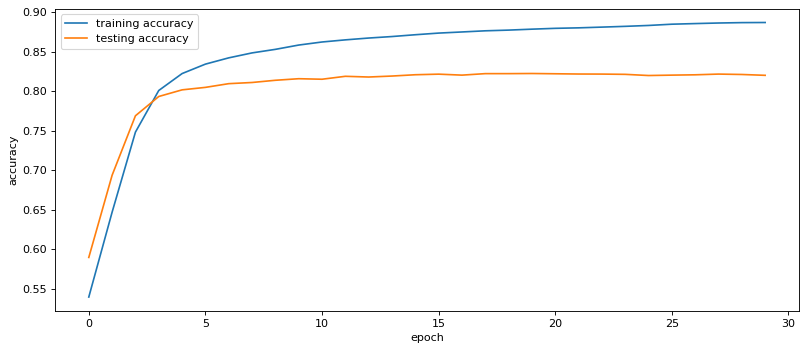

In [10]:
print("-------------")
print(filtered_lemmas[0:50])
print(list(w2i.keys())[:200])
print(list(i2w.keys())[:200])

network = train_sgns(filtered_lemmas, 5, 8, w2i, i2w)
embedding = network.embedding

In [11]:
print(embedding.weight)
print(embedding.weight.shape)

Parameter containing:
tensor([[ 7.6026, -6.2995,  2.3524,  ...,  7.0148,  1.3901, -7.4198],
        [ 7.7760, -6.2499,  2.5278,  ...,  6.9197,  1.2211, -7.6557],
        [ 6.8884, -5.3807,  2.1789,  ...,  6.0350,  1.1414, -6.7891],
        ...,
        [-1.7445,  1.3203, -0.2115,  ...,  0.5601,  1.0873, -0.2234],
        [ 1.9146, -1.3860,  2.9537,  ..., -0.4948,  1.0601,  1.0890],
        [ 8.4557, -6.6240,  2.7695,  ...,  7.6706,  1.5470, -8.1726]],
       requires_grad=True)
torch.Size([2560, 8])


### Reduce the Dimensionality of Embeddings and Display

Visualizing the 20 to 80 most frequent words


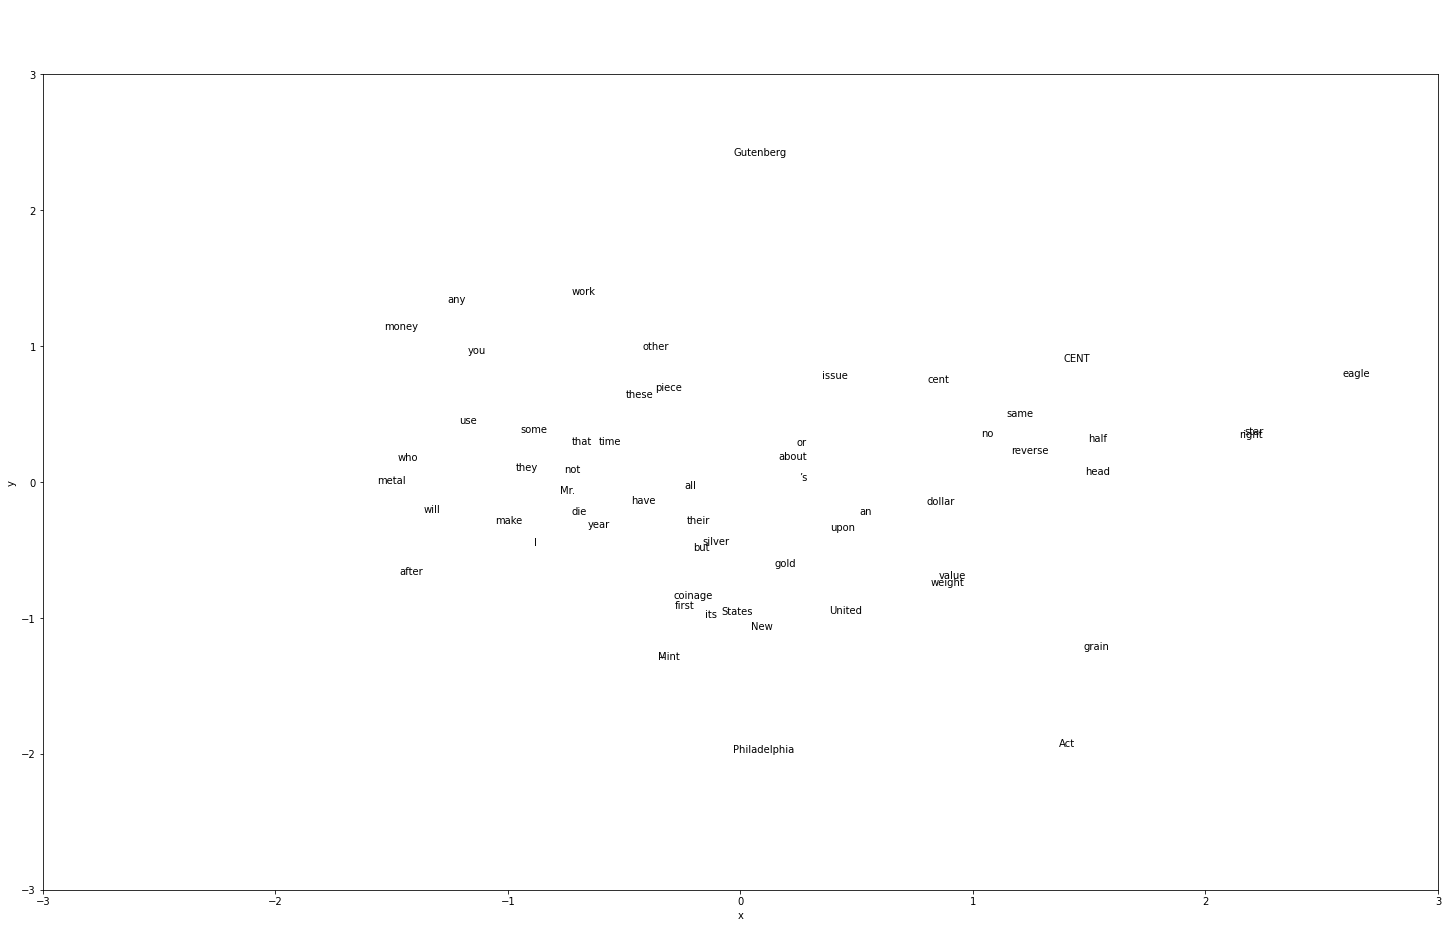

In [19]:
from sklearn.decomposition import PCA #see https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

def visualize_embedding(embedding, most_frequent_from=20, most_frequent_to=80):
    print ("Visualizing the {} to {} most frequent words".format(most_frequent_from, most_frequent_to))
    
    # since the embeddings are ordered from most frequent words to least frequent, 
    # we can easily select a sub range of the most frequent words:
    
    selected_words = embedding[most_frequent_from:most_frequent_to, :]
    # The function below will reduce a vector to 2 principle components
    
    pca = PCA(n_components=2)
    
    # Transform the selected embeddings to have 2 dimensions
    
    embeddings = pca.fit_transform(selected_words)
    
    # Plot the the reduced embeddings - a point and the word itself
    
    # TO DO
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure

    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(25)

    for index, embedding in enumerate(embeddings):
        ax.annotate(i2w[index+most_frequent_from], (embedding[0], embedding[1]))
        
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

visualize_embedding(embedding.weight.detach().numpy(), most_frequent_from=20, most_frequent_to=80)

